In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense, BatchNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['JNJ.csv']))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

Saving JNJ.csv to JNJ.csv


In [ ]:
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['RSI'] = 100 - (100 / (1 + df['Close'].diff().apply(lambda x: x if x > 0 else 0).rolling(window=14).mean() / df['Close'].diff().apply(lambda x: -x if x < 0 else 0).rolling(window=14).mean()))
df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df.fillna(method='bfill', inplace=True)

In [ ]:
features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'EMA_20', 'RSI', 'OBV']].values


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

In [ ]:
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length, 3])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_features, sequence_length)

train_size = int(len(X) * 0.8)
train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:], y[train_size:]

In [ ]:
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(100, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    BatchNormalization(),
    GRU(100, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    BatchNormalization(),
    GRU(100, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


In [ ]:
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_split=0.1, verbose=1, callbacks=[early_stopping, reduce_lr])


Epoch 1/100
352/352 [==============================] - 42s 94ms/step - loss: 0.7236 - val_loss: 0.2444 - lr: 0.0010
Epoch 2/100
352/352 [==============================] - 34s 97ms/step - loss: 0.2656 - val_loss: 0.1623 - lr: 0.0010
Epoch 3/100
352/352 [==============================] - 32s 92ms/step - loss: 0.1481 - val_loss: 0.1183 - lr: 0.0010
Epoch 4/100
352/352 [==============================] - 32s 91ms/step - loss: 0.1044 - val_loss: 0.0898 - lr: 0.0010
Epoch 5/100
352/352 [==============================] - 32s 91ms/step - loss: 0.0798 - val_loss: 0.0697 - lr: 0.0010
Epoch 6/100
352/352 [==============================] - 32s 92ms/step - loss: 0.0619 - val_loss: 0.0545 - lr: 0.0010
Epoch 7/100
352/352 [==============================] - 32s 90ms/step - loss: 0.0479 - val_loss: 0.0413 - lr: 0.0010
Epoch 8/100
352/352 [==============================] - 31s 89ms/step - loss: 0.0364 - val_loss: 0.0310 - lr: 0.0010
Epoch 9/100
352/352 [==============================] - 32s 91ms/step - l

In [ ]:
predicted_prices = model.predict(test_X)
predicted_prices_extended = np.zeros((predicted_prices.shape[0], scaled_features.shape[1]))
predicted_prices_extended[:, 3] = predicted_prices[:, 0]
predicted_prices = scaler.inverse_transform(predicted_prices_extended)[:, 3]

test_y_extended = np.zeros((test_y.shape[0], scaled_features.shape[1]))
test_y_extended[:, 3] = test_y
real_prices = scaler.inverse_transform(test_y_extended)[:, 3]

98/98 [==============================] - 4s 23ms/step


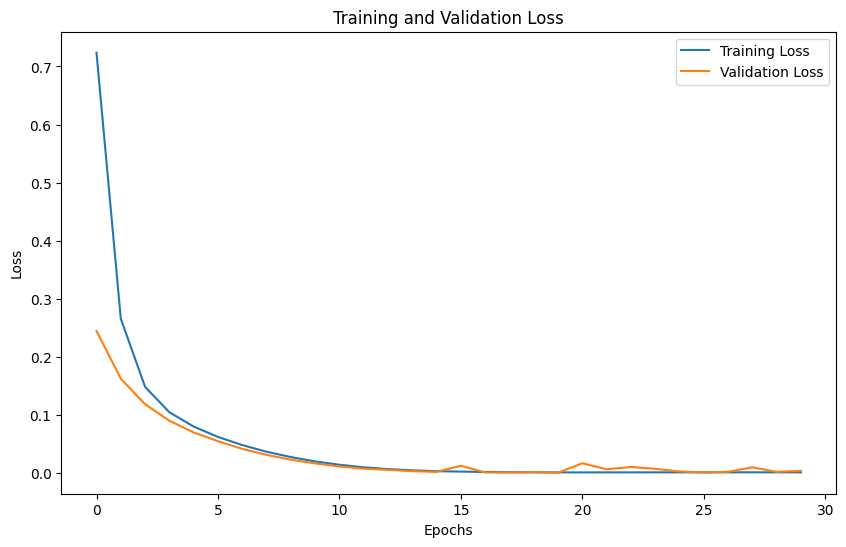

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

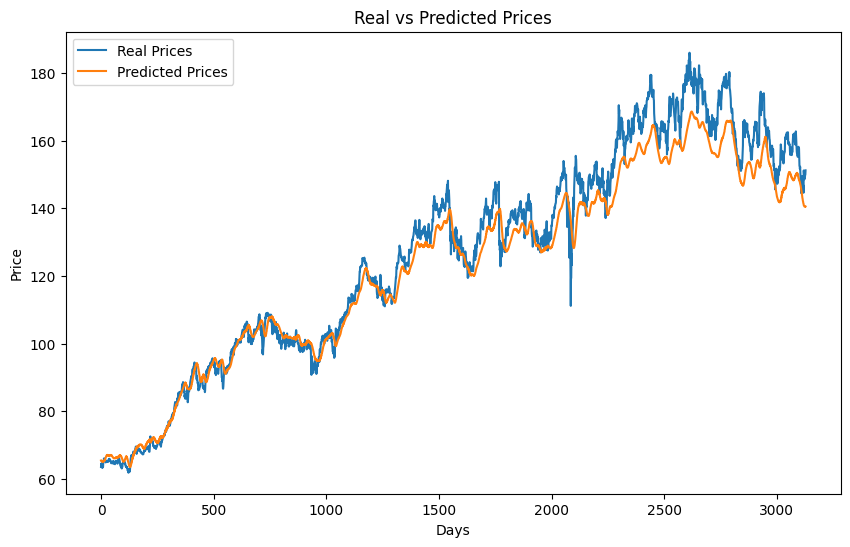

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(real_prices, label='Real Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.title('Real vs Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()